#Analysis of CrowdFlower job #755704: sentence-level chemical-induced disease relationship extraction for BioCreative V

Tong Shu Li<br>
Created on Friday, 2015-07-24<br>
Last updated 2015-07-28

Previous work with CrowdFlower tasks #746297 and #748223 showed that:

1. Workers performed best on relations which were sentence bound.
2. Workers missed some relations when multiple relations were presented.
3. Workers picked out the easiest relations to verify when multiple relations were presented.
4. Concept name replacement with the semantic type had little influence on performance.

Based on these observations, I decided to make the following changes:

1. Split the task into two subtasks: one where the relation is sentence bound, and one where the relation is not sentence bound. While the underlying task is almost identical, this allows payments to be structured differently and hopefully for tasks to be processed faster.
2. Reduce the number of relations to verify for each passage of text from five to one. This allows each judgement to be simplified to a binary judgement.

This notebook will analyze the results of the sentence-level task.

Parameter | Value
--- | ---
Job ID | #755704
Rows per page | 5
Judgements per row | 5
Payment per page | 15 cents USD
Contributor level | 2
Minimum time per page | 15 seconds
Minimum accuracy threshold | 70%
Number of test questions | 23
Date of launch | 3:05 pm on Thursday, July 23, 2015
Date of completion | 4:50 pm on Thursday, July 23, 2015
Total cost before bonuses | \$39.78 USD
Total cost after bonuses | $39.78 USD

---

#Are there any sentence-bound relationships which the crowd said "no" for all sentences but the gold says yes? (false negatives)

###Analysis workflow:

For the sentence-based task, we took all the drug-disease id pairs from the abstract and searched for sentences where we the two terms co-occurred. We then use these individual sentences as one CrowdFlower task. Workers only ever work on the individual task level, so it is our job to reaggregate the results back together.

For a single drug-disease id pair, there may exist multiple sentences where the two terms co-occur. When this happens, each sentence becomes its own separate CrowdFlower task. In order to determine whether this relationship is true at the abstract level, we assume that, if at least one sentence says that the relationship is true, then the relationship is also true at the abstract level.

This assumption relies upon the fact that sentences are not working together to produce a relationship that none of they individually support. It assumes that if a sentence gets no signal saying that the relationship is true, then it likely means that either the sentence does not say anything about the relation, or the sentence says that the relation is not true.

Therefore if one sentence says the relationship exists, then the relationship exists at the abstract level. If all sentences say no, then the relationship is no at the abstract level.

In order to aggregate the confidence scores, we do the following:<br>
The confidence score of a relationship at the abstract level aggregated from multiple sentence-level tasks is the maximum of the individual confidence scores of the sentence level work units. Therefore the relationship is as certain as the most certain sentence work unit.

We are using the positive signal only confidence score, since the analysis of job 754530 showed that it was equivalent to (and slightly better than) majority voting, and the resulting metric is more intuitive.

---

In [1]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from IPython.display import Image
from operator import add
import matplotlib as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
%%bash

rm src/get_AUC_value.pyc

In [4]:
from src.filter_data import filter_data
from src import data_model
from src.data_model import parse_input
from src.data_model import Relation
from src.get_AUC_value import get_AUC_value
from src.F_score import *

###Read the results of job #755704:

In [5]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_755704_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [6]:
raw_data.shape

(815, 26)

In [7]:
raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,worker_confidence,disease_id,disease_name,drug_id,drug_name,form_sentence,pmid,uniq_id,verify_relationship_gold,worker_confidence_gold
0,759110536,7/23/2015 22:31:03,False,1697093814,NaN,7/23/2015 22:29:28,False,elite,0.7143,30936260,...,very_confident,D016171,"<span class=""disease"">TDP</span>",C063968,"<span class=""chemical"">E4031</span>",Four compounds known to increase QT interval a...,11569530,bcv_easy_0,NaN,NaN
1,759110536,7/23/2015 22:31:23,False,1697094162,NaN,7/23/2015 22:29:21,False,elite,1.0000,32708888,...,very_confident,D016171,"<span class=""disease"">TDP</span>",C063968,"<span class=""chemical"">E4031</span>",Four compounds known to increase QT interval a...,11569530,bcv_easy_0,NaN,NaN
2,759110536,7/23/2015 22:31:37,False,1697094429,NaN,7/23/2015 22:29:24,False,clixsense,0.7500,32958339,...,confident,D016171,"<span class=""disease"">TDP</span>",C063968,"<span class=""chemical"">E4031</span>",Four compounds known to increase QT interval a...,11569530,bcv_easy_0,NaN,NaN
3,759110536,7/23/2015 22:31:47,False,1697094613,NaN,7/23/2015 22:29:20,False,clixsense,0.7778,32298558,...,confident,D016171,"<span class=""disease"">TDP</span>",C063968,"<span class=""chemical"">E4031</span>",Four compounds known to increase QT interval a...,11569530,bcv_easy_0,NaN,NaN
4,759110536,7/23/2015 22:31:50,False,1697094647,NaN,7/23/2015 22:29:30,False,clixsense,0.7333,32471798,...,confident,D016171,"<span class=""disease"">TDP</span>",C063968,"<span class=""chemical"">E4031</span>",Four compounds known to increase QT interval a...,11569530,bcv_easy_0,NaN,NaN


###User comments:

In [8]:
raw_data[~pd.isnull(raw_data["comment_box"])]

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,worker_confidence,disease_id,disease_name,drug_id,drug_name,form_sentence,pmid,uniq_id,verify_relationship_gold,worker_confidence_gold
257,759110583,7/23/2015 22:57:33,False,1697116864,NaN,7/23/2015 22:40:51,False,clixsense,0.9091,28745592,...,not_too_confident,D007022,"<span class=""disease"">hypotensive</span>",D015742,"<span class=""chemical"">propofol</span>",We investigated the safety and efficacy of add...,10520387,bcv_easy_46,NaN,NaN
349,759110600,7/23/2015 22:40:48,False,1697102953,NaN,7/23/2015 22:32:11,False,clixsense,0.9091,28745592,...,not_confident,D009408,"<span class=""disease"">compression neuropathy</...",D010423,"<span class=""chemical"">pentazocine</span>","However, <span class=""disease"">compression neu...",3800626,bcv_easy_63,NaN,NaN
411,759110612,7/23/2015 22:57:33,False,1697116863,NaN,7/23/2015 22:40:51,False,clixsense,0.9091,28745592,...,not_too_confident,D001523,"<span class=""disease"">hallucinosis</span>",C009265,"<span class=""chemical"">carbidopa/levodopa</span>",Two patients with similar clinical features ar...,2265898,bcv_easy_75,NaN,NaN
640,759110660,7/23/2015 22:49:24,False,1697110527,NaN,7/23/2015 22:43:19,False,neodev,1.0000,32591740,...,not_too_confident,D002318|D005767,"<span class=""disease"">cardiovascular and gastr...",D013806,"<span class=""chemical"">theophylline</span>","While side effects were rare, those experience...",1835291,bcv_easy_118,NaN,NaN
706,759110672,7/23/2015 22:38:04,False,1697100535,NaN,7/23/2015 22:35:16,False,elite,1.0000,32708888,...,not_too_confident,D004342,"<span class=""disease"">allergy</span>",D010248,"<span class=""chemical"">paramethasone</span>","To our knowledge, this is the first report of ...",7582165,bcv_easy_130,NaN,NaN


In [9]:
raw_data["comment_box"].unique()

array([nan, 'Causation was only implied. Need more context.',
       'A little ambiguous. The statement presupposed they were indirectly related, but no clinical evidence has been reported.',
       'The anticonvulsants carbidopa/levodopa might or might not cause hallucinosis.',
       'This excersise makes no sense. None of the three options is correct, because the sentence talks about systems and not desease or conditions. Anyway i choose the first option, because the alleged side effect is related to the cardiovascular or gastrointestinal system',
       "If this is the first report of such connection EVER, than maybe, paramethasone DOESN'T cause allergy after all... Like, that was a one-time fluke, an exception, not a rule..."], dtype=object)

##Notes:

Unit 759110600 PMID 3800626 is an example where the "yes-indirect" choice worked as intended. 4/5 workers chose the indirect relationship and correctly identified that myopathy was what was causing compression neuropathy, not the pentazocine directly. The gold has the relation between pentazocine and compression neuropathy, so we will need to look at that. This shows me that it's helpful to have this choice, and to post-process whether this is yes or no rather than having the workers decide that themselves. It gives us more flexibility.

Unit 759110660 PMID 1835291. The comment correctly identified that the "disease" highlighted in the question is not actually a disease, but rather a set of systems.

The comments are actually pretty helpful this time. In general though it will be hard to deal with the comments in an automated way.

###Contentions:

This time the test question contentions did not identify any egregiously bad test questions. Most of the test questions had high passing rates. Workers rated the test question fairness as 3.5/5, which is also reasonable.

# Give the option for workers to identify incorrect NER and incorrectly split sentences?

###Result aggregation:

In [10]:
def aggregate_votes(column_name, data_frame, mapping = None):
    """
    Given all of the human responses for one work unit,
    aggregates the results based on the column you give it.

    For each possible choice, it calculates:
        1. Total number of votes for that choice.
        2. Sum of trust scores of people who chose that choice.

    Returns an unsorted data frame of the results.

    Confidence score is the sum of the trust score of
    individual workers.
    
    If given a mapping, will convert answers.
    """
    # number of votes and sum trust score for each unique choice
    res = dict()
    for value, group in data_frame.groupby(column_name):
        conf_score = sum(group["_trust"])
        num_votes = len(group) # assuming unique workers for each work unit
        
        if mapping is not None and value in mapping: # only convert those which need to be changed
            value = mapping[value]
            
        if value in res:
            res[value] = map(add, res[value], [conf_score, num_votes])
        else:
            res[value] = [conf_score, num_votes]
            
    temp = [[key] + value for key, value in res.items()] # make rows of data frame
    return pd.DataFrame(temp, columns = [column_name, "conf_score", "num_votes"])

In [11]:
"""
Takes raw CrowdFlower data and groups data together by
individual work units. Aggregates the votes based on
a specific column and creates a summary data frame.
"""
def aggregate_results(id_column, agg_column, data, reporting_method, metadata_columns,
                      reporting_value = None, mapping = None):
    """
    Collect votes together for each individual work unit.
    Choose one of two result reporting methods:
        1. Majority vote
        2. Positive signal only
        
    reporting_method: {"majority_vote", "positive_signal_only"}
    if reporting_method == "positive_signal_only":
        reporting_value is the label of the positive value in the aggregation column
    """
    assert reporting_method in {"majority_vote", "positive_signal_only"}, "Wrong result reporting method!"
    
    result = []
    for identifier, group in data.groupby(id_column):
        # group the votes together and convert if necessary
        ans = aggregate_votes(agg_column, group, mapping)
        
        if reporting_method == "positive_signal_only":
            positive_result = ans.query("{0} == '{1}'".format(agg_column, reporting_value))
            if positive_result.empty:
                # no worker chose the positive choice, so create an empty entry
                temp = pd.DataFrame([[reporting_value, 0, 0]], columns = [agg_column, "conf_score", "num_votes"])
                ans = ans.append(temp)
        
        # figure out what percentage of the workers chose each choice
        total_vote_score = sum(ans["conf_score"])
        ans.loc[:, "percent_agree"] = ans.loc[:, "conf_score"] / total_vote_score
        
        ans.insert(0, id_column, identifier)
        
        # copy the metadata columns over (e.g., pmid, unit id)
        for column_name in metadata_columns:
            assert len(group[column_name].unique()) == 1
            value = group[column_name].iloc[0]
            ans.loc[:, column_name.lstrip('_')] = value
            
        # sort results
        # decreasing confidence score if doing majority vote
        # put positive result at the top if doing positive result method
        
        if reporting_method == "majority_vote":
            ans = ans.sort(["conf_score"], ascending = False)
            result.append(ans)
        else:
            # put positive result at the top
            positive_result = ans.query("{0} == '{1}'".format(agg_column, reporting_value))
            temp = ans.query("{0} != '{1}'".format(agg_column, reporting_value))
            temp = temp.sort(["conf_score"], ascending = False)
            
            result.append(pd.concat([positive_result, temp]))

    return pd.concat(result)

In [12]:
res = aggregate_results("uniq_id", "verify_relationship", raw_data, "majority_vote", ["pmid", "_unit_id"])

In [13]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
1,bcv_easy_0,yes_direct,3.2254,4,0.81134,11569530,759110536
0,bcv_easy_0,yes_indirect,0.7500,1,0.18866,11569530,759110536
0,bcv_easy_1,yes_direct,4.1246,5,1.00000,11569530,759110537
0,bcv_easy_10,no_relation,4.3540,5,1.00000,11135224,759110547
0,bcv_easy_100,yes_direct,4.5270,5,1.00000,8590259,759110641


# error: work unit 759110545 should be yes...

#When making work units for sentences, include a unique identifier for relation pairs with the same chemical and disease ids from the same abstract. This will let me count afterwards how many sentences to combine together

###Which units had "yes_indirect" as the top answer?

In [14]:
for unit_id, group in res.groupby("unit_id"):
    if group["verify_relationship"].iloc[0] == "yes_indirect":
        print unit_id
        print group
        print

759110566.0
       uniq_id verify_relationship  conf_score  num_votes  percent_agree  \
0  bcv_easy_29        yes_indirect      2.9375          3       0.629878   
1  bcv_easy_29          yes_direct      1.7261          2       0.370122   

      pmid    unit_id  
0  1378968  759110566  
1  1378968  759110566  

759110585.0
       uniq_id verify_relationship  conf_score  num_votes  percent_agree  \
0  bcv_easy_48        yes_indirect      2.8261          3       0.605991   
1  bcv_easy_48          yes_direct      1.8375          2       0.394009   

       pmid    unit_id  
0  10520387  759110585  
1  10520387  759110585  

759110600.0
       uniq_id verify_relationship  conf_score  num_votes  percent_agree  \
0  bcv_easy_63        yes_indirect      3.6727          4       0.824344   
1  bcv_easy_63         no_relation      0.7826          1       0.175656   

      pmid    unit_id  
0  3800626  759110600  
1  3800626  759110600  

759110674.0
        uniq_id verify_relationship  conf_s

There are 6 work units where the top crowd response was "yes_indirect". After manual review, I determined that:

759110566, 759110585, 759110600, 759110674, 759110700 are indeed drug -> disease -> disease relationships.

759110680 is a special case, since it can indeed be interpreted as death resulting from cardiorespiratory arrest, and not from midazolam directly.

Again, I'm very happy that the crowd can identify these kinds of relationships.

###Dealing with yes_indirect relationships:

1. Treating it as a "no" vote
2. Treating it as a "yes" vote

In [15]:
res_yes = aggregate_results("uniq_id", "verify_relationship", raw_data,
                           "positive_signal_only", ["pmid", "_unit_id"], "yes_direct", {"yes_indirect" : "yes_direct"})

res_no = aggregate_results("uniq_id", "verify_relationship", raw_data,
                           "positive_signal_only", ["pmid", "_unit_id"], "yes_direct", {"yes_indirect" : "no_relation"})

In [16]:
res_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_easy_0,yes_direct,3.9754,5,1,11569530,759110536
0,bcv_easy_1,yes_direct,4.1246,5,1,11569530,759110537
0,bcv_easy_10,yes_direct,0.0000,0,0,11135224,759110547
0,bcv_easy_10,no_relation,4.3540,5,1,11135224,759110547
0,bcv_easy_100,yes_direct,4.5270,5,1,8590259,759110641


In [17]:
res_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_easy_0,yes_direct,3.2254,4,0.81134,11569530,759110536
1,bcv_easy_0,no_relation,0.7500,1,0.18866,11569530,759110536
0,bcv_easy_1,yes_direct,4.1246,5,1.00000,11569530,759110537
0,bcv_easy_10,yes_direct,0.0000,0,0.00000,11135224,759110547
0,bcv_easy_10,no_relation,4.3540,5,1.00000,11135224,759110547


###Select only the positive results for subsequent analysis:

In [18]:
res_yes = res_yes.query("verify_relationship == 'yes_direct'")

In [19]:
res_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_easy_0,yes_direct,3.9754,5,1.000000,11569530,759110536
0,bcv_easy_1,yes_direct,4.1246,5,1.000000,11569530,759110537
0,bcv_easy_10,yes_direct,0.0000,0,0.000000,11135224,759110547
0,bcv_easy_100,yes_direct,4.5270,5,1.000000,8590259,759110641
0,bcv_easy_101,yes_direct,1.6039,2,0.403964,12198388,759110642


In [20]:
res_no = res_no.query("verify_relationship == 'yes_direct'")

In [21]:
res_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id
0,bcv_easy_0,yes_direct,3.2254,4,0.811340,11569530,759110536
0,bcv_easy_1,yes_direct,4.1246,5,1.000000,11569530,759110537
0,bcv_easy_10,yes_direct,0.0000,0,0.000000,11135224,759110547
0,bcv_easy_100,yes_direct,4.5270,5,1.000000,8590259,759110641
0,bcv_easy_101,yes_direct,1.6039,2,0.403964,12198388,759110642


---

###Read the gold standard:

In [22]:
if os.path.exists("data/training/parsed_training_set.pickle"):
    print "Reading cached version of training set"
    with open("data/training/parsed_training_set.pickle", "rb") as fin:
        training_data = pickle.load(fin)
else:
    training_data = parse_input("data/training", "CDR_TrainingSet.txt")
    with open("data/training/parsed_training_set.pickle", "wb") as fout:
        pickle.dump(training_data, fout)

Reading cached version of training set


In [23]:
import random
random.seed("2015-06-11:14:46")

In [24]:
TESTSET_SIZE = 30
testset = random.sample(training_data, TESTSET_SIZE)

testset_pmids = {paper.pmid for paper in testset}
testset_pmids

# print len(testset_pmids)

{1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 2515254,
 3800626,
 6666578,
 6692345,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10520387,
 10835440,
 11135224,
 11569530,
 12041669,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 17931375,
 18631865,
 19269743}

In [25]:
def get_subset(dataset, papers):
    return {paper.pmid : paper for paper in papers if paper.pmid in dataset}

testset = get_subset(testset_pmids, training_data)

In [26]:
len(testset)

30

---

###Evaluate crowd performance against the gold standard:

In [27]:
def determine_truth(dataframe):
    """
    Add the in_gold column to each row.
    """
    def is_in_gold(uniq_id):
        res = raw_data.query("uniq_id == '{0}'".format(uniq_id))
        chemical_id = res["drug_id"].iloc[0]
        disease_id = res["disease_id"].iloc[0]
        pmid = res["pmid"].iloc[0]
        
        return int(testset[pmid].has_relation(Relation(chemical_id, disease_id)))
    
    def chem_id(uniq_id):
        return raw_data.query("uniq_id == '{0}'".format(uniq_id))["drug_id"].iloc[0]

    def dise_id(uniq_id):
        return raw_data.query("uniq_id == '{0}'".format(uniq_id))["disease_id"].iloc[0]
    
    dataframe.loc[:, "in_gold"] = dataframe.loc[:, "uniq_id"].map(is_in_gold)
    dataframe.loc[:, "chemical_id"] = dataframe.loc[:, "uniq_id"].map(chem_id)
    dataframe.loc[:, "disease_id"] = dataframe.loc[:, "uniq_id"].map(dise_id)
    return dataframe

In [28]:
perf_yes = determine_truth(res_yes)

In [29]:
perf_yes.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,in_gold,chemical_id,disease_id
0,bcv_easy_0,yes_direct,3.9754,5,1.000000,11569530,759110536,0,C063968,D016171
0,bcv_easy_1,yes_direct,4.1246,5,1.000000,11569530,759110537,1,D020117,D016171
0,bcv_easy_10,yes_direct,0.0000,0,0.000000,11135224,759110547,0,D017239,D002289
0,bcv_easy_100,yes_direct,4.5270,5,1.000000,8590259,759110641,1,C016986,D015814
0,bcv_easy_101,yes_direct,1.6039,2,0.403964,12198388,759110642,0,D000109,D012640


In [30]:
perf_no = determine_truth(res_no)

In [31]:
perf_no.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,in_gold,chemical_id,disease_id
0,bcv_easy_0,yes_direct,3.2254,4,0.811340,11569530,759110536,0,C063968,D016171
0,bcv_easy_1,yes_direct,4.1246,5,1.000000,11569530,759110537,1,D020117,D016171
0,bcv_easy_10,yes_direct,0.0000,0,0.000000,11135224,759110547,0,D017239,D002289
0,bcv_easy_100,yes_direct,4.5270,5,1.000000,8590259,759110641,1,C016986,D015814
0,bcv_easy_101,yes_direct,1.6039,2,0.403964,12198388,759110642,0,D000109,D012640


---

###Aggregate the results of the individual sentences together at the abstract level:

The number of unique (pmid, chemical_id, disease_id) triples is fewer than the number of unique work units.

In [32]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        norm_conf_score = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["in_gold"].append(group["in_gold"].iloc[0])
        
        res["norm_conf_score"].append(norm_conf_score)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        
    return pd.DataFrame(res)

In [33]:
perf_yes = aggregate_sentences(perf_yes)

In [34]:
perf_yes.head()

,chemical_id,disease_id,in_gold,norm_conf_score,pmid,uniq_ids,unit_ids
0,D002512,D007674,0,0.815789,1130930,bcv_easy_153,759110695
1,D002512,D007683,1,0.831219,1130930,bcv_easy_152,759110694
2,D002512,D009846|D051437,1,1.000000,1130930,bcv_easy_151,759110693
3,D005839,D007674,0,0.812966,1130930,bcv_easy_150,759110692
4,D005839,D007683,1,1.000000,1130930,bcv_easy_149,759110691


In [35]:
perf_no = aggregate_sentences(perf_no)

In [36]:
perf_no.head()

,chemical_id,disease_id,in_gold,norm_conf_score,pmid,uniq_ids,unit_ids
0,D002512,D007674,0,0.815789,1130930,bcv_easy_153,759110695
1,D002512,D007683,1,0.831219,1130930,bcv_easy_152,759110694
2,D002512,D009846|D051437,1,0.818547,1130930,bcv_easy_151,759110693
3,D005839,D007674,0,0.812966,1130930,bcv_easy_150,759110692
4,D005839,D007683,1,1.000000,1130930,bcv_easy_149,759110691


In [37]:
max_F_score("norm_conf_score", "in_gold", perf_yes)

F_score      0.826087
precision    0.745098
recall       0.926829
threshold    0.822736
Name: 20, dtype: float64

In [38]:
max_F_score("norm_conf_score", "in_gold", perf_no)

F_score      0.833333
precision    0.813953
recall       0.853659
threshold    0.815541
Name: 19, dtype: float64

In [39]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))

    graph.set_xlim((0, 1.1))
    graph.set_ylim((0, 1.1))

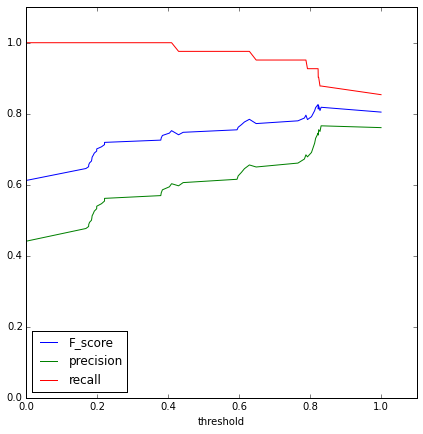

In [40]:
plot_results("norm_conf_score", "in_gold", perf_yes)

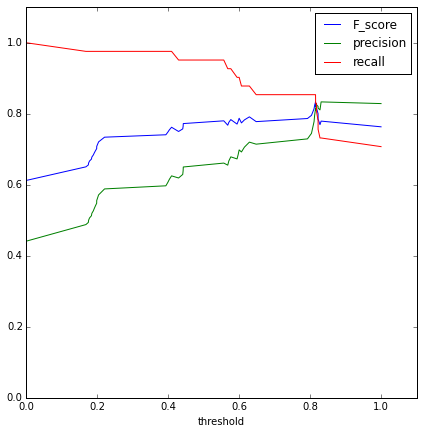

In [41]:
plot_results("norm_conf_score", "in_gold", perf_no)

The plots look very different depending on how you treat the indirect relationships.

---

###Combine the results of the abstract-level task, the sentence-level task, and the automatically extracted CID relations:

In [42]:
abs_lvl_rels = pd.read_csv("data/abstract_level_relations.tsv", sep = '\t')

In [43]:
abs_lvl_rels.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,in_gold,chemical_id,disease_id
0,bcv_hard_0,yes_direct,0.0000,0,0.000000,11569530,756359591,0,C063968,D017180
1,bcv_hard_1,yes_direct,1.6904,2,0.398877,11569530,756359592,0,D020117,D017180
2,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,1,C056507,D013921
3,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,0,C056507,D003643
4,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,1,C056507,D009503


In [44]:
with open("data/cid_relations.pickle", "rb") as fin:
    cid_relations = pickle.load(fin)

In [45]:
cid_relations

{(1378968, 'D008094', 'D007674'),
 (1378968, 'D008094', 'D007676'),
 (2096243, 'C017367', 'D019965'),
 (2096243, 'C017367', 'D056784'),
 (3800626, 'D010423', 'D005355|D009135'),
 (3800626, 'D010423', 'D009135'),
 (6666578, 'D010396', 'D001018'),
 (12041669, 'D010396', 'D000741'),
 (15632880, 'D013148', 'D006947'),
 (15632880, 'D013148', 'D051437'),
 (17241784, 'D019821', 'D009135'),
 (17261653, 'D003000', 'D001919'),
 (19269743, 'D002211', 'D010146')}

---

My workflow decision maker isn't quite perfect, so the aggregation will be a little annoying...

In [46]:
abs_triples = set()
for info, group in abs_lvl_rels.groupby(["pmid", "chemical_id", "disease_id"]):
    abs_triples.add((int(info[0]), info[1], info[2]))

In [47]:
sentence_triples = set()
for info, group in perf_no.groupby(["pmid", "chemical_id", "disease_id"]):
    sentence_triples.add((int(info[0]), info[1], info[2]))

In [48]:
abs_triples & sentence_triples

{(1130930, 'D002512', 'D007674'),
 (1130930, 'D005839', 'D007674'),
 (2265898, 'C009265', 'D004827'),
 (3800626, 'D010423', 'D009408|D020425'),
 (7582165, 'D000305', 'D004342'),
 (16337777, 'D010862', 'D004827')}

In [49]:
cid_relations & abs_triples

{(1378968, 'D008094', 'D007676'), (6666578, 'D010396', 'D001018')}

In [50]:
cid_relations & sentence_triples

{(2096243, 'C017367', 'D019965'),
 (3800626, 'D010423', 'D005355|D009135'),
 (12041669, 'D010396', 'D000741'),
 (15632880, 'D013148', 'D006947'),
 (15632880, 'D013148', 'D051437'),
 (17241784, 'D019821', 'D009135'),
 (19269743, 'D002211', 'D010146')}

The decision maker is leaky. Some relationships show up multiple times, which needs to be fixed.

In [51]:
# combine results

total_res = defaultdict(list)

for triple in cid_relations:
    total_res["pmid"].append(triple[0])
    total_res["chemical_id"].append(triple[1])
    total_res["disease_id"].append(triple[2])
    
    total_res["norm_conf_score"].append(1.0)
    total_res["in_gold"].append(int(testset[triple[0]].has_relation(Relation(triple[1], triple[2]))))

# abstract
for triple, group in abs_lvl_rels.groupby(["pmid", "chemical_id", "disease_id"]):
    total_res["pmid"].append(triple[0])
    total_res["chemical_id"].append(triple[1])
    total_res["disease_id"].append(triple[2])
    
    assert len(group) == 1
    total_res["norm_conf_score"].append(group["percent_agree"].iloc[0])
    total_res["in_gold"].append(group["in_gold"].iloc[0])
    
# sentences
for triple, group in perf_no.groupby(["pmid", "chemical_id", "disease_id"]):
    total_res["pmid"].append(triple[0])
    total_res["chemical_id"].append(triple[1])
    total_res["disease_id"].append(triple[2])
    
    assert len(group) == 1
    total_res["norm_conf_score"].append(group["norm_conf_score"].iloc[0])
    total_res["in_gold"].append(group["in_gold"].iloc[0])
    
total_res = pd.DataFrame(total_res)

# remove duplicates
indicies = []
for triple, group in total_res.groupby(["pmid", "chemical_id", "disease_id"]):
    group = group.sort("norm_conf_score", ascending = False)
    
    indicies.append(group.index[0])
    
total_res = total_res.loc[indicies]

In [52]:
# no more duplicates
total_res["in_gold"].sum()

63

In [53]:
total_res

,chemical_id,disease_id,in_gold,norm_conf_score,pmid
110,D002512,D007674,0,0.815789,1130930
111,D002512,D007683,1,0.831219,1130930
112,D002512,D009846|D051437,1,0.818547,1130930
14,D002512,D051437,0,0.195645,1130930
15,D005839,D007674,0,1.000000,1130930
114,D005839,D007683,1,1.000000,1130930
115,D005839,D009846|D051437,1,1.000000,1130930
16,D005839,D051437,0,0.189596,1130930
17,D003404,D005921,0,0.000000,1378968
18,D003404,D006973,0,0.000000,1378968


##Results for all 30 abstracts of the testset with aggregated results from the sentence and abstract level tasks, including the CID relations

In [54]:
max_F_score("norm_conf_score", "in_gold", total_res)

F_score      0.830769
precision    0.805970
recall       0.857143
threshold    0.810811
Name: 31, dtype: float64

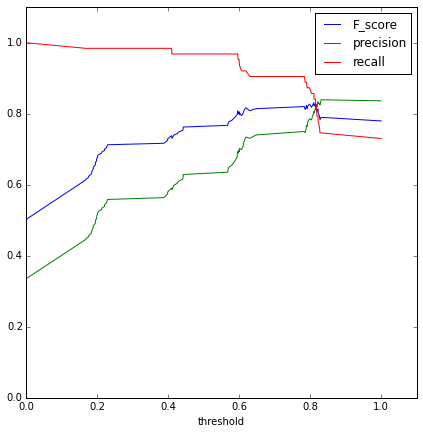

In [55]:
plot_results("norm_conf_score", "in_gold", total_res)

In [56]:
fname = "data/roc/testset_final_results.png"
title = "ROC for 30 abstracts, combined results of abstract, sentence, and CID relations"
get_AUC_value(total_res, "norm_conf_score", "in_gold", fname, title)

0.9254603174603173

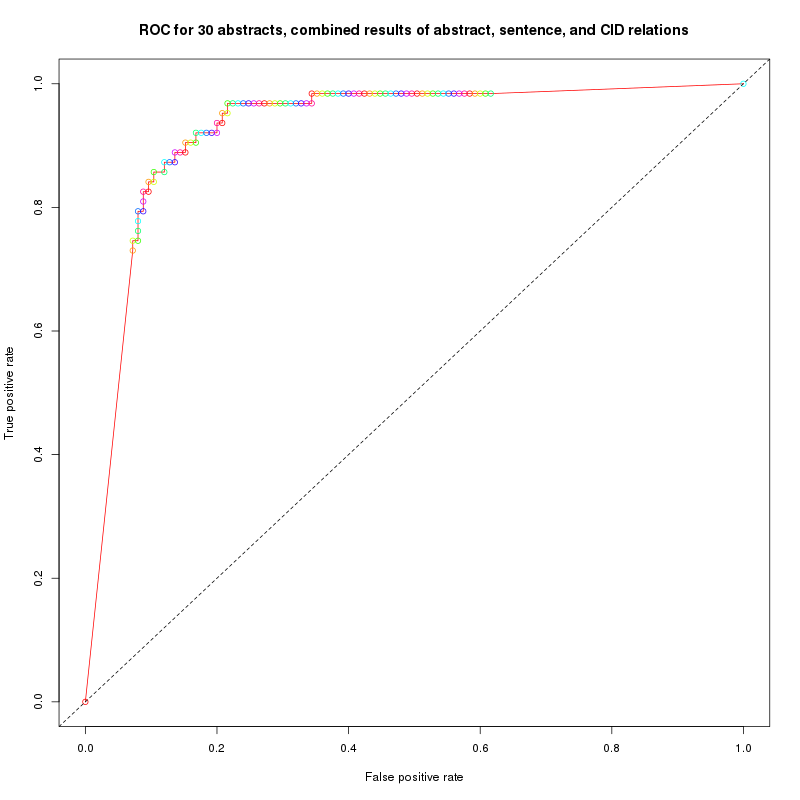

In [57]:
Image(fname)

---

###Result aggregation using majority voting:

We can also aggregate the results using majority voting, and using logical OR to determine if the relation is true at the abstract level. This method does not perform as well as the other evaluation scheme.

#Rewrite the missing analysis with the old method

In [37]:
perf_statistics(abs_perf_yes)

true pos 40
true neg 27
false pos 25
false neg 1

precision 0.615384615385
recall 0.975609756098
F score 0.754716981132


In [38]:
perf_statistics(abs_perf_no)

true pos 39
true neg 32
false pos 20
false neg 2

precision 0.661016949153
recall 0.951219512195
F score 0.78


---

#Test to see if giving crowd the ability to vote on the NER is going to improve performance

For example, on work unit 759110650, the "disease" highlighted is "convulsants", which is given in the gold as MeSH:D012640, which in MeSH is "seizures". The crowd chose "yes direct" relationship, but in reality convulsants isn't being used as a disease here. This was a false positive in our results, but an error in the NER. At the moment we have no ability to detect NER errors, and is required by hand.

The crowd should probably be reasonable at detecting NER problems though, especially if I give them the meaning of the specific mesh id that the highlighted text is supposed to be.


>Read this sentence. We think the highlighted term means "mesh id name", and that it is a disease/chemical. Does this sound correct based on the context of the sentence? yes/no answer